In [1]:
from itertools import cycle
from typing import Dict, List
from matplotlib import pyplot as plt
import numpy as np
import pandas as pd
import sklearn
from sklearn.base import BaseEstimator
from sklearn.datasets import load_iris
from sklearn.ensemble import RandomForestClassifier
from sklearn.model_selection import train_test_split

from deepchecks import CheckResult, Dataset, SingleDatasetBaseCheck
from deepchecks.base import ConditionResult, CheckSuite

np.random.seed(42)

In [2]:
iris_df = load_iris(return_X_y=False, as_frame=True)['frame']
label_col = 'target'
df_train, df_test = train_test_split(iris_df, stratify=iris_df[label_col], random_state=0)
ds_iris = Dataset(iris_df, label=label_col)
ds_train = Dataset(df_train, label=label_col)
ds_test =  Dataset(df_test,  label=label_col)

In [3]:
ds_test.data

,sepal length (cm),sepal width (cm),petal length (cm),petal width (cm),target
39,5.1,3.4,1.5,0.2,0
12,4.8,3.0,1.4,0.1,0
48,5.3,3.7,1.5,0.2,0
23,5.1,3.3,1.7,0.5,0
81,5.5,2.4,3.7,1.0,1
55,5.7,2.8,4.5,1.3,1
99,5.7,2.8,4.1,1.3,1
9,4.9,3.1,1.5,0.1,0
85,6.0,3.4,4.5,1.6,1
129,7.2,3.0,5.8,1.6,2


In [4]:
rf_clf = RandomForestClassifier()
rf_clf.fit(ds_train.features_columns(), ds_train.label_col());

In [5]:
class CustomCheck(SingleDatasetBaseCheck):
    def __init__(self, selected_feature: str, bins_amount: int = 3):
        self.selected_feature = selected_feature
        self.bins_amount = bins_amount
        super().__init__()

    def run(self, dataset: Dataset, model: BaseEstimator) -> CheckResult:
        binned_col_name = self.selected_feature + ' binned'
        y_pred = model.predict(dataset.features_columns())

        min_val = dataset.data[self.selected_feature].min()
        max_val = dataset.data[self.selected_feature].max()
        increment = (max_val - min_val) / self.bins_amount
        
        bins = []
        labels = []
        for i in range(self.bins_amount):
            labels.append(i + 1)
            bins.append(min_val + i * increment)
        bins.append(min_val + self.bins_amount * increment)
        df = dataset.data.copy()
        df[binned_col_name] = pd.cut(dataset.data[self.selected_feature], bins, labels=labels, include_lowest=True)
        df['y_pred'] = y_pred

        targets = dataset.label_col().unique()
        dist_ratio = {}
        for bin_i in range(self.bins_amount): 
            dist_ratio[bin_i] = {}
            for target in targets:
                dist = df.loc[df[binned_col_name] == (bin_i + 1)]
                tot_in_bin = len(dist)
                tot_of_target = len(dist.loc[dist['y_pred'] == target])
                dist_ratio[bin_i][target] = tot_of_target / tot_in_bin
        dist_ratio['original'] = {}
        len_df = len(df)
        for target in targets:
            tot_of_target = len(df.loc[df['y_pred'] == target])
            dist_ratio['original'][target] = tot_of_target / len_df  

        def display():
            targets_range = (dataset.label_col().min(), dataset.label_col().max())
            fig, axs = plt.subplots(1, self.bins_amount + 1, tight_layout=True)
            plt.setp(axs, xticks=targets)
            for i in range(self.bins_amount):
                dist = df.loc[df[binned_col_name] == (i + 1)]['y_pred']
                axs[i].hist(dist, range=targets_range)
                axs[i].set_xlabel(f'bin {i+1}')
            axs[self.bins_amount].hist(df['y_pred'], range=targets_range)
            axs[self.bins_amount].set_xlabel('original dataset')

        return CheckResult(dist_ratio, display=display, check=self.__class__)

In [6]:
val = CustomCheck('sepal width (cm)', bins_amount = 3).run(ds_test, rf_clf)

Custom Check

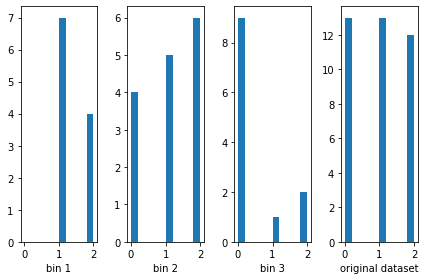

In [7]:
val

In [9]:
def add_condition_distribution_change_not_greater_than(self, max_change = 0.33):
    def condition(result: Dict) -> ConditionResult:
        failed_bins = {}
        original_dist = result.pop('original')
        for bin_i in result.keys():
            failed_targets = {}
            for target in original_dist.keys():
                bin_ratio = result[bin_i][target]
                original_ratio = original_dist[target]
                change = bin_ratio - original_ratio
                change = max(change, -change)
                if change > max_change:
                    failed_targets[target] = f'target {target}: ratio {bin_ratio} vs {original_ratio}'
            if failed_targets:
                failed_bins[bin_i + 1] = f'bin {bin_i + 1}: {list(failed_targets.values())}'
        if failed_bins:
            return ConditionResult(False,
                                   f'{list(failed_bins.values())}')
        else:
            return ConditionResult(True)

    return self.add_condition(f'Change_not_greater_than {max_change}', condition)

In [10]:
CustomCheck.add_condition_distribution_change_not_greater_than = add_condition_distribution_change_not_greater_than

In [11]:
check = CustomCheck('sepal width (cm)').add_condition_distribution_change_not_greater_than()

Custom Suite 
 The suite is composed of various checks such as: Custom Check, etc... 
 Each check may contain conditions (which results in 
 ✓ /
 ✖ /
 ! 
 ), as well as other outputs such as plots or tables. 
 Suites, checks and conditions can all be modified (see tutorial [link]). 
 Conditions Summary

Status,Check,Condition,More Info
✖,Custom Check - Test Dataset,Change_not_greater_than 0.33,"[""bin 1: ['target 0: ratio 0.0 vs 0.34210526315789475']"", ""bin 3: ['target 0: ratio 0.75 vs 0.34210526315789475']""]"


Additional Outputs

Custom Check - Test Dataset

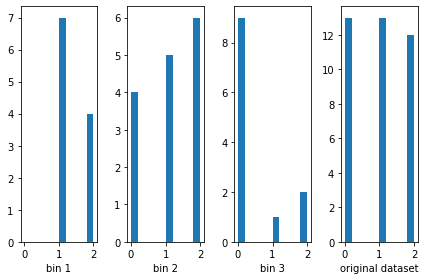

In [12]:
CheckSuite('Custom Suite', check).run(train_dataset=ds_train, test_dataset=ds_test, model=rf_clf, check_datasets_policy='test')